# **Optimization - Exercise 3 - Projected Gradient Descent**
---

In [ ]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Recall the naive gradient descent implementation:

In [ ]:
# You can pass functions as parameters to other functions.
# In this case, gradient and objective are functions
def naive_gradient_descent(x_0, max_iters, gamma, gradient, objective):
    """Gradient descent algorithm."""
    solutions = [x_0]
    scores = [objective(x_0)]
    x = x_0
    for n_iter in range(max_iters):
        grad = gradient(x)
        x = x - gamma * grad
        score = objective(x)
        solutions.append(x)
        scores.append(score)
    return solutions, scores

The basic concept of **projected gradient descent** is that an optimization problem of the form $\min f(\mathbf{x})$ could include additional constraints of the form $\mathbf{x} \in X$. The naive gradient descent algorithm only tries to solve the minimization problem, but does not guarantee that the new value of $\mathbf{x}$ after every step will be contained in the feasible region $X$.

For example, let us consider this very simple problem:

$
\begin{aligned}
\min f(x) = x^2&\\
s.t. x \geq -2 &\\
\end{aligned}
$

The feasible region of this problem is $X = \{x \geq -2\}$, but we don't have any guarantee that the gradient descent algorithm would produce feasible solutions at every step (independently from the chosen learning rate).

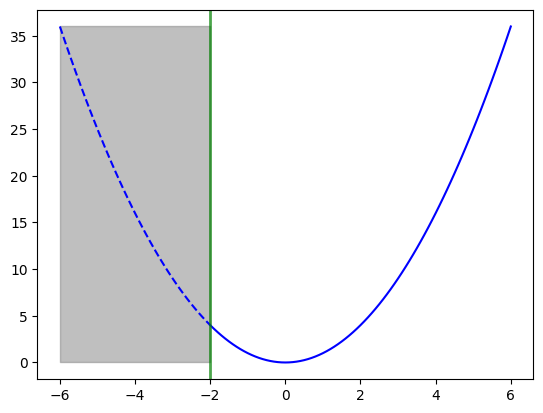

In [ ]:
def plot_parable(threshold, width):
    infeasible_x = np.arange(-width, threshold+0.1, 0.1)
    plt.plot(infeasible_x, infeasible_x**2, linestyle='dashed', color='blue')

    feasible_x = np.arange(threshold, width+0.1, 0.1)
    plt.plot(feasible_x, feasible_x**2, color='blue')

    # grey region is infeasible
    plt.axvline(threshold, color='green', lw=2, alpha=0.7)

    plt.fill_between(infeasible_x, width**2, color='grey', alpha=0.5)

# Plot a parable in the interval [-6,6] with feasible region x > -2
plot_parable(threshold=-2, width=6)

# Projection step

In order to always remain in the feasible region, the idea is to project onto $X$ after every step: $\Pi_X (\mathbf{y}) := argmin_{\mathbf{x} \in X} \|\mathbf{x} − \mathbf{y}\|^2$.

The basic step $\mathbf{x}_{t+1} = \mathbf{x}_t - \gamma \nabla f(\mathbf{x}_t)$ becomes then $\mathbf{x}_{t+1} = \Pi_X[\mathbf{x}_t - \gamma \nabla f(\mathbf{x}_t)]$.

In [ ]:
# lambda x: x is an anonymous function passed as a default parameter
# (don't do any projection if the projection function is not specified)
def projected_gradient_descent(x_0,
                               max_iters,
                               gamma,
                               gradient,
                               objective,
                               projection=lambda x: x):
    """Gradient descent algorithm with projection."""
    solutions = [x_0]
    scores = [objective(x_0)]
    x = x_0
    for n_iter in range(max_iters):
        grad = gradient(x)
        x = x - gamma * grad

        # project onto the feasible region
        x = projection(x)

        score = objective(x)
        solutions.append(x)
        scores.append(score)
    return solutions, scores

We can start testing this implementation without any projection (note how the gradient descent bounces between the feasible and infeasible region, as we can see in the printed figure).

best value of x after 30 iterations: 0.0061897001964269175


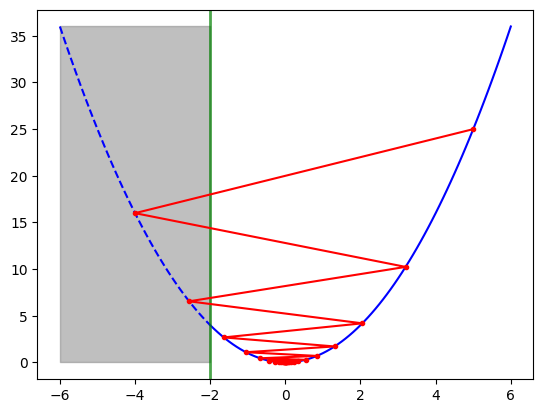

In [ ]:
def objective(x):
    return x**2

def gradient(x):
    return 2*x


# Try different values for x_0 and gamma
x_0 = 5
max_iters = 30
gamma = 0.9

solutions, scores = projected_gradient_descent(x_0, max_iters, gamma, gradient, objective)

# Plot the original function
plot_parable(-2, 6)

# Add to plot the values of x at the various steps (in red)
plt.plot(solutions, scores, '.-', color='red')

# Read the best (possibly infeasible) value of x found so far
print("best value of x after", max_iters, "iterations:" , solutions[-1])

Now we can define an appropriate projection function. This is not an easy task in general, since calculating $\Pi_X (\mathbf{y})$ could be an optimization problem itself. Fortunately, in the case $f(x) = x^2$ we are optimizing over a single variable and the feasible region $X$ is the interval $[-2,+\infty]$. So, the projection step will simply return $\Pi_X (y) = y$ if $y >= -2$, and $\Pi_X (y) = -2$ otherwise (this is a problem in a single dimension and any $y > -2$ is feasible, so the closest point to the feasible region will always be $y = -2$).

best value of x after 1 iterations: -4.0
best projected value of x after 1 iterations: -2.0


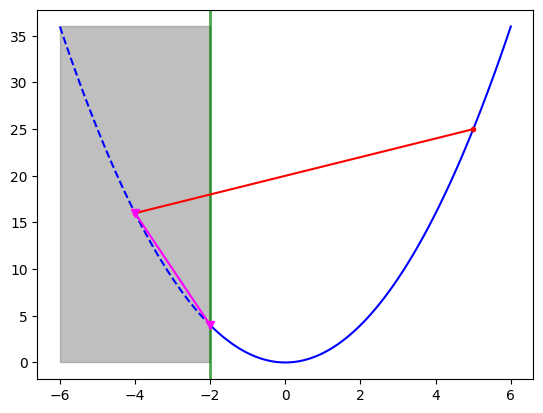

In [ ]:
def monodimensional_projection(x):
    """project x onto the interval [-2, +inf]"""
    if x < -2.0:
        x = -2.0
    return x

# Run with 1 iteration to see the projection
x_0 = 5
max_iters = 1
gamma = 0.9

solutions, scores = naive_gradient_descent(x_0, max_iters, gamma, gradient, objective)
proj_solutions, proj_scores = projected_gradient_descent(x_0, max_iters, gamma, gradient, objective, monodimensional_projection)

plot_parable(-2, 6)

# Plot original first step
plt.plot(solutions, scores, '.-', color='red')

# Plot first step with projection
#plt.plot(proj_solutions, proj_scores, '.-', color='purple')

# Projection step
plt.plot([solutions[1], proj_solutions[1]], [scores[1], proj_scores[1]], color='magenta', marker='v')

print("best value of x after", max_iters, "iterations:" , solutions[-1])
print("best projected value of x after", max_iters, "iterations:" , proj_solutions[-1])

best projected value of x after 30 iterations: 0.0030948500982134588


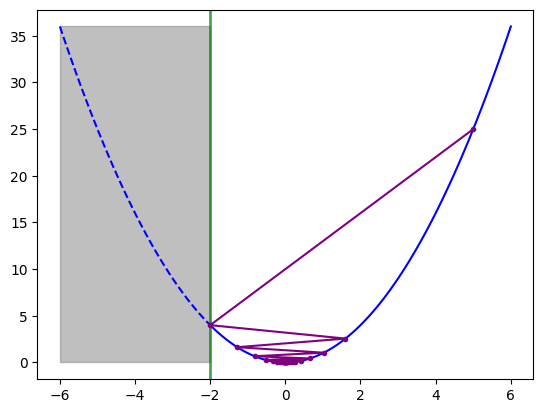

In [ ]:
# The whole projected gradient descent looks like this
max_iters = 30
proj_solutions, proj_scores = projected_gradient_descent(x_0, max_iters, gamma, gradient, objective, monodimensional_projection)

plot_parable(-2, 6)

# Plot original first step
plt.plot(proj_solutions, proj_scores, '.-', color='purple')

print("best projected value of x after", max_iters, "iterations:" , proj_solutions[-1])

# Projecting onto an Euclidean ball

We can apply the projected gradient descent algorithm to optimization problems with any number of dimensions, provided that we have an appropriate projection function.

For now we consider only the simple case where the feasible region $X$ is an Euclidean ball centered on the origin, assuming the optimal solution to lie within a fixed radius $r$ from the origin. When the optimization problem has two variables, $X$ is an actual 2-dimensional ball like in the picture:

![](https://i.ibb.co/cFsCFr0/Euclidean-Ball.png)

In this case, the projection requires simply to scale the vector $\mathbf{y}$: if the Euclidean norm $\|\mathbf{y}\|$ is greater than the ball radius $r$, the projection step will be $\Pi_X (\mathbf{y}) = r \frac{\mathbf{y}}{\|\mathbf{y}\|}$, otherwise $\mathbf{y}$ is in the feasible region already and no projection is needed.

## More complex data

Note that this kind of proposed projection function is defined on any number of dimensions; we can apply it to the same 8-dimensional Least Squares problem proposed in Exercise 2. Assuming the optimal solution to lie in an Euclidean ball of radius $r = 10$ centered on the origin, we are solving the following optimization problem:

$
\begin{aligned}
\min f(\mathbf{x}) = \|A\mathbf{x} - \mathbf{b}\|^2&\\
s.t. \|\mathbf{x}\| \leq 10 &\\
\end{aligned}
$

In [ ]:
from sklearn.datasets import fetch_california_housing

# Loads sklearn's California Housing dataset
dataset = fetch_california_housing()

# Use all but the last column as dimensions
features = dataset.data
prices = dataset.target

def standardize(x):
    """Standardize the original data points (mean 0 and std dev 1)."""
    x = x - np.mean(x)
    x = x / np.std(x)
    return x

def build_model_data(x, y):
    """Get regression data in matrix form."""
    b = y
    num_samples = len(b)
    A = np.c_[np.ones(num_samples), x]
    return A, b

A, b = build_model_data(standardize(features), standardize(prices))


# Gradient descent implementation
def calculate_objective(A, x, b):
    Axmb = A.dot(x) - b
    return (Axmb**2).sum()

def compute_gradient(A, x, b):
    Axmb = A.dot(x) - b
    grad = 2 * A.T.dot(Axmb)
    return grad

def ball_projection(x):
    """project x onto an Euclidean ball of radius 10"""
    ball_radius = 10
    norm = np.linalg.norm(x)
    if norm > ball_radius:
        x = x * (ball_radius / norm)
    return x

def proj_gradient_descent(A, initial_x, b, max_iters, gamma, projection=lambda x: x):
    xs = [initial_x]
    objectives = []
    x = initial_x
    for n_iter in range(max_iters):
        grad = compute_gradient(A, x, b)
        x = x - gamma * grad

        # project onto the feasible region
        x = projection(x)

        # compute the norm of x (distance from the origin)
        x_norm = np.linalg.vector_norm(x)

        xs.append(x)
        obj = calculate_objective(A, x, b)
        objectives.append(obj)

        print("Gradient Descent({bi}/{ti}): objective={l:.5f}, norm_of_x={n:.5f}, x=[{w0:.5f},{w1:.5f},{w2:.5f},{w3:.5f},{w4:.5f},{w5:.5f},{w6:.5f},{w7:.5f},{w8:.5f}]".format(
              bi=n_iter, ti=max_iters - 1, l=obj, n=x_norm, w0=x[0], w1=x[1], w2=x[2], w3=x[3], w4=x[4], w5=x[5], w6=x[6], w7=x[7], w8=x[8]))

    return objectives, xs


Note that even if the projected gradient descent will never diverge (since the value of $\mathbf{x}$ at every step will lie within the feasible region $X$), the convergence to the optimal value is still not guaranteed for arbitrary learning rates: if $\gamma$ is too large, the algorithm can get stuck and bounce forever on the borders of the feasible region.

In [ ]:
# Run naive version with fixed learning rate
max_iters = 30
x_initial = np.zeros(A.shape[1])

gamma_naive = 0.0001
# This is too large: without projection it would diverge, with projection it
# will bounce forever on the borders of the feasible region
#gamma_naive = 0.000001

gradient_objectives, gradient_xs = proj_gradient_descent(A, x_initial, b, max_iters, gamma_naive, ball_projection)

Gradient Descent(0/29): objective=20637.07690, norm_of_x=0.00186, x=[0.00000,0.00009,0.00009,0.00002,-0.00000,-0.00185,-0.00002,-0.00002,-0.00001]
Gradient Descent(1/29): objective=20635.60951, norm_of_x=0.00315, x=[0.00016,0.00013,0.00014,0.00001,-0.00005,-0.00314,-0.00008,-0.00008,-0.00009]
Gradient Descent(2/29): objective=20634.77748, norm_of_x=0.00409, x=[0.00041,0.00015,0.00017,-0.00004,-0.00012,-0.00405,-0.00016,-0.00015,-0.00021]
Gradient Descent(3/29): objective=20634.22825, norm_of_x=0.00481, x=[0.00072,0.00015,0.00018,-0.00010,-0.00021,-0.00472,-0.00026,-0.00024,-0.00036]
Gradient Descent(4/29): objective=20633.80999, norm_of_x=0.00539, x=[0.00107,0.00014,0.00019,-0.00016,-0.00030,-0.00522,-0.00037,-0.00034,-0.00054]
Gradient Descent(5/29): objective=20633.45706, norm_of_x=0.00590, x=[0.00144,0.00013,0.00019,-0.00024,-0.00041,-0.00561,-0.00049,-0.00044,-0.00072]
Gradient Descent(6/29): objective=20633.14080, norm_of_x=0.00636, x=[0.00182,0.00011,0.00018,-0.00032,-0.00051,-0.